In [202]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from src.hmm import LinearHMM
from src.kalman_filter import KalmanFilter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
np.random.seed(1)

In [249]:
N = 3
dx = 2
dv = dx
dw = dx
dy = 1

A = 0.5 * np.random.normal(size=(dx, dx))
B = 0.1 * np.random.normal(size=(dx, dv))
C = np.random.normal(size=(dy, dx))
D = np.random.normal(size=(dy, dw))
Q = np.eye(dv)
R = np.eye(dw)
P = np.eye(dx)

linear_hmm = LinearHMM(A, B, C, D, Q, R, P, N=N)

In [250]:
n_steps = 5
linear_hmm.simulate(n_steps)

In [251]:
latent = linear_hmm.latent
obs = linear_hmm.obs

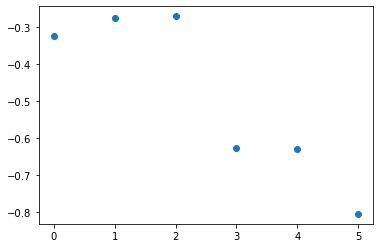

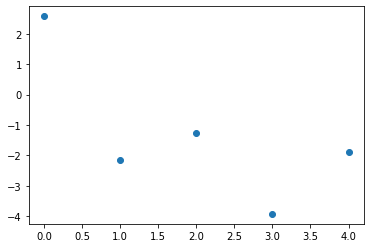

In [227]:
plt.scatter(range(n_steps + 1), latent[:, 0, 0])
plt.show()
plt.scatter(range(n_steps), obs[:, 0, 0])
plt.show()

In [228]:
# exact inference via kalman filter
kalman_filter = KalmanFilter(
    obs=obs,
    prior_latent_mean=np.zeros((1, dx)),
    prior_latent_var=P,
    A=A,
    B=B,
    C=C,
    D=D,
    R=R,
    Q=Q
)

In [233]:
posterior_mean, posterior_var = kalman_filter.fit()

In [234]:
posterior_samples = np.random.multivariate_normal(
    posterior_mean[0, :], posterior_var, 1000)

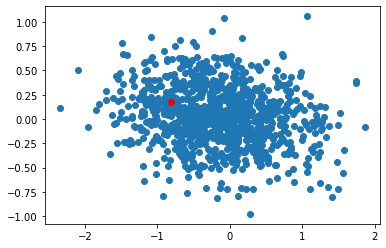

In [241]:
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1])
plt.scatter(latent[-1, 0, 0], latent[-1, 0, 1], color="r")

# Sequential IS

In [275]:
# from src.proposal import proposal
from scipy.stats import multivariate_normal

In [276]:
proposal_var = 2.
proposal = multivariate_normal(np.zeros(dx), proposal_var * np.eye(dx))

In [277]:
proposal.logpdf(np.zeros(dx))

-2.5310242469692907